<a href="https://colab.research.google.com/github/Vikas-KM/amazon_fine_food_review/blob/main/amazon_fine_food_review_sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Context
This dataset consists of reviews of fine foods from amazon. The data span a period of more than 10 years, including all ~500,000 reviews up to October 2012. Reviews include product and user information, ratings, and a plain text review. It also includes reviews from all other Amazon categories.

Data includes:

- Reviews from Oct 1999 - Oct 2012
- 568,454 reviews
- 256,059 users
- 74,258 products
- 260 users with > 50 reviews

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/amazon-fine-food-reviews/hashes.txt
/kaggle/input/amazon-fine-food-reviews/Reviews.csv
/kaggle/input/amazon-fine-food-reviews/database.sqlite


In [2]:
import pandas as pd
import numpy as np

In [2]:
! pip install -q kaggle

In [3]:
! pip install --upgrade --force-reinstall --no-deps kaggle

     |████████████████████████████████| 61kB 3.3MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.10-cp36-none-any.whl size=73269 sha256=4fa96bc723f09670fee91ba6f2738cb5113e65315e9c02b106a8b8454ff6be8a
  Stored in directory: /root/.cache/pip/wheels/3a/d1/7e/6ce09b72b770149802c653a02783821629146983ee5a360f10
Successfully built kaggle
  Found existing installation: kaggle 1.5.10
    Uninstalling kaggle-1.5.10:
      Successfully uninstalled kaggle-1.5.10


In [4]:
from google.colab import files

In [5]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"vikaskm","key":"bf11c9724b1364b3e91bee662fb79ca3"}'}

In [6]:
! mkdir ~/.kaggle

In [7]:
cp kaggle.json ~/.kaggle/

In [8]:
! chmod 600 ~/.kaggle/kaggle.json

In [9]:
! kaggle datasets list

ref                                                            title                                                size  lastUpdated          downloadCount  voteCount  usabilityRating  
-------------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
utkarshxy/who-worldhealth-statistics-2020-complete             World Health 2020 🌏 | For Geospatial Analysis         1MB  2021-01-06 16:22:50            941        128  1.0              
gpreda/pfizer-vaccine-tweets                                   Pfizer Vaccine Tweets                               403KB  2021-01-06 15:11:07            713         73  1.0              
google/android-smartphones-high-accuracy-datasets              Android smartphones high accuracy GNSS datasets       1GB  2020-12-23 01:51:11            136         29  0.875            
ashkhagan/women-representation-in-city-property-sanfrancisco   Wo

In [10]:
! pip install --upgrade --force-reinstall --no-deps kaggle

Processing /root/.cache/pip/wheels/3a/d1/7e/6ce09b72b770149802c653a02783821629146983ee5a360f10/kaggle-1.5.10-cp36-none-any.whl
  Found existing installation: kaggle 1.5.10
    Uninstalling kaggle-1.5.10:
      Successfully uninstalled kaggle-1.5.10


In [11]:
! kaggle datasets download -d snap/amazon-fine-food-reviews

100% 241M/242M [00:12<00:00, 22.6MB/s]
100% 242M/242M [00:12<00:00, 19.6MB/s]


In [12]:
! ls

amazon-fine-food-reviews.zip  kaggle.json  sample_data


In [13]:
! unzip amazon-fine-food-reviews.zip 

Archive:  amazon-fine-food-reviews.zip
  inflating: Reviews.csv             
  inflating: database.sqlite         
  inflating: hashes.txt              


In [14]:
! ls

amazon-fine-food-reviews.zip  hashes.txt   Reviews.csv
database.sqlite		      kaggle.json  sample_data


In [15]:
df = pd.read_csv('Reviews.csv')
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      568454 non-null  int64 
 1   ProductId               568454 non-null  object
 2   UserId                  568454 non-null  object
 3   ProfileName             568438 non-null  object
 4   HelpfulnessNumerator    568454 non-null  int64 
 5   HelpfulnessDenominator  568454 non-null  int64 
 6   Score                   568454 non-null  int64 
 7   Time                    568454 non-null  int64 
 8   Summary                 568427 non-null  object
 9   Text                    568454 non-null  object
dtypes: int64(5), object(5)
memory usage: 43.4+ MB


In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [4]:
# NLP Packages
from wordcloud import WordCloud
import nltk
from nltk import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from nltk.corpus import stopwords

In [5]:
import re
from bs4 import BeautifulSoup

In [20]:
# null values
df.isna().sum()

Id                         0
ProductId                  0
UserId                     0
ProfileName               16
HelpfulnessNumerator       0
HelpfulnessDenominator     0
Score                      0
Time                       0
Summary                   27
Text                       0
dtype: int64

## Basic EDA

In [21]:
# words per review
words_per_review = df['Text'].apply(lambda x: len(x.split(' ')))

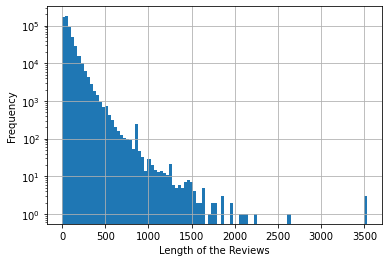

In [22]:
words_per_review.hist(bins=100)
plt.yscale('log', nonposy='clip')
plt.xlabel('Length of the Reviews')
plt.ylabel('Frequency')
plt.show()

In [23]:
print('Average words per review ', words_per_review.mean())
print('skewness ', words_per_review.skew())

Average words per review  82.00552199474363
skewness  4.665196605688608


In [24]:
# distribution of ratings across reviews
ratings = (df['Score'].value_counts()/len(df))*100
ratings

5    63.878871
4    14.188483
1     9.194763
3     7.501047
2     5.236835
Name: Score, dtype: float64

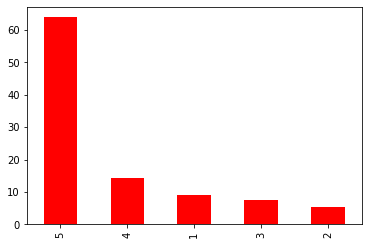

In [25]:
ratings.plot.bar(color='red')

### Observation
- Too many 5 ratings and than other ratings
- max review length is between 0 to 500 words

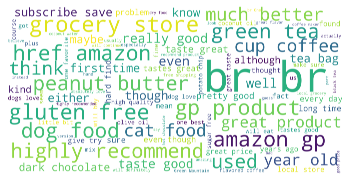

In [26]:

word_cloud_text = ''.join(df['Text'])

wordcloud = WordCloud(max_font_size=100, # Maximum font size for the largest word
                      max_words=100, # The maximum number of words
                      background_color="white", # Background color for the word cloud image
                      scale = 10, # Scaling between computation and drawing
                      width=800, # Width of the canvas
                      height=400 # Height of the canvas
                     ).generate(word_cloud_text)

plt.figure()
plt.imshow(wordcloud, 
           interpolation="bilinear") # to make the displayed image appear more smoothly
plt.axis("off")
plt.show()

## Data Cleaning

In [27]:
df.isna().sum()

Id                         0
ProductId                  0
UserId                     0
ProfileName               16
HelpfulnessNumerator       0
HelpfulnessDenominator     0
Score                      0
Time                       0
Summary                   27
Text                       0
dtype: int64

### Observation
- Since we are more concerned with the text, and score, which dont have null we will not drop NaN values here

### mapping of score
- we want to say positive review for score 4 and 5
- and score 1 and 2 as negative
- score 3 is neutral, so we will drop those values

In [28]:
df['sentiment'] = np.where(df['Score']>3, 1, 0)
df['sentiment'].head()

0    1
1    0
2    1
3    0
4    1
Name: sentiment, dtype: int64

In [29]:
df.shape

(568454, 11)

In [30]:
df = df[df['Score'] != 3]
df.shape

(525814, 11)

we just dropped all the neutral values ie.[](http://) score=3

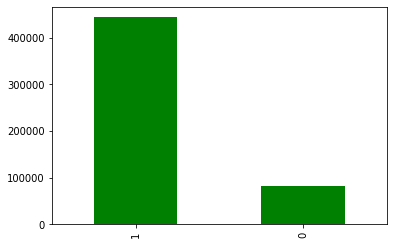

In [31]:
df['sentiment'].value_counts().plot.bar(color='green')

### Observation
- too many positive reviews
- data is imbalanced


## Text Preprocessing
- converting to lower case
- removing html tags
- removing special characters
- remove words which have numbers in them
- Removing stop words
- stemming and lemmatization

In [32]:
# converting to lower case
df['Text'] = df['Text'].str.lower()
df['Text'].head()

0    i have bought several of the vitality canned d...
1    product arrived labeled as jumbo salted peanut...
2    this is a confection that has been around a fe...
3    if you are looking for the secret ingredient i...
4    great taffy at a great price.  there was a wid...
Name: Text, dtype: object

In [33]:
# https://stackoverflow.com/questions/11331982/how-to-remove-any-url-within-a-string-in-python/40823105#40823105
def remove_URL(text):
    """Remove URLs from a text string"""
    return re.sub(r"http\S+", "", text)

In [34]:
# removing any urls from the review text
df['Text'] = df['Text'].apply(lambda x: remove_URL(x))
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,sentiment
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,i have bought several of the vitality canned d...,1
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,product arrived labeled as jumbo salted peanut...,0
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",this is a confection that has been around a fe...,1
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,if you are looking for the secret ingredient i...,0
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,great taffy at a great price. there was a wid...,1


In [35]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
def getText(x):
    soup = BeautifulSoup(x, 'lxml')
    text = soup.get_text()
    return text

In [36]:
# removing any tags present
df['Text'] = df['Text'].apply(lambda x: getText(x))
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,sentiment
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,i have bought several of the vitality canned d...,1
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,product arrived labeled as jumbo salted peanut...,0
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",this is a confection that has been around a fe...,1
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,if you are looking for the secret ingredient i...,0
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,great taffy at a great price. there was a wid...,1


In [37]:
# removing special characters
def remove_spl(x):
    x = re.sub('[^A-Za-z0-9]+', ' ', x)
    return x

In [38]:
# removing special characters from the review text
df['Text'] = df['Text'].apply(lambda x: remove_spl(x))
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,sentiment
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,i have bought several of the vitality canned d...,1
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,product arrived labeled as jumbo salted peanut...,0
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",this is a confection that has been around a fe...,1
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,if you are looking for the secret ingredient i...,0
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,great taffy at a great price there was a wide ...,1


In [39]:
df.iloc[0].Text

'i have bought several of the vitality canned dog food products and have found them all to be of good quality the product looks more like a stew than a processed meat and it smells better my labrador is finicky and she appreciates this product better than most '

#### remove words which have numbers in them
eg: amazi646g hello46747**

In [40]:
def remove_num_words(x):
    x = re.sub('\w*\d\w*', ' ', x)
    return x

In [41]:
# removing words having numbers in them
df['Text'] = df['Text'].apply(lambda x: remove_num_words(x))
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,sentiment
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,i have bought several of the vitality canned d...,1
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,product arrived labeled as jumbo salted peanut...,0
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",this is a confection that has been around a fe...,1
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,if you are looking for the secret ingredient i...,0
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,great taffy at a great price there was a wide ...,1


#### lets pickle the cleaned data before proceeding and applying word tokenizer
- https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.to_pickle.html

In [42]:
df.to_pickle('data_clean.pkl')

In [43]:
df = pd.read_pickle('data_clean.pkl')
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,sentiment
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,i have bought several of the vitality canned d...,1
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,product arrived labeled as jumbo salted peanut...,0
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",this is a confection that has been around a fe...,1
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,if you are looking for the secret ingredient i...,0
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,great taffy at a great price there was a wide ...,1


#### Removing stop words
- https://www.geeksforgeeks.org/removing-stop-words-nltk-python/

In [51]:
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')

print(stopwords.fileids())

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
['arabic', 'azerbaijani', 'danish', 'dutch', 'english', 'finnish', 'french', 'german', 'greek', 'hungarian', 'indonesian', 'italian', 'kazakh', 'nepali', 'norwegian', 'portuguese', 'romanian', 'russian', 'slovene', 'spanish', 'swedish', 'tajik', 'turkish']


In [52]:
stop_words = set(stopwords.words('english'))
print(stop_words)

{'those', "shan't", "don't", 'with', 'o', 'then', 'in', 'y', 'shan', 'hadn', "you'll", 'each', 'hers', 'doing', 'me', 're', 'haven', 'into', 'aren', "didn't", 'a', 'all', 'isn', 't', "wasn't", 'most', 'they', "you've", 'd', "doesn't", 'we', 'mightn', 'very', "isn't", 'theirs', 'that', 'about', 'above', 'once', 'where', 'weren', 'ma', 'ours', 'she', "mightn't", 'it', 'won', 'does', 'themselves', 'll', 'some', 'because', 'wouldn', 'what', 'have', 'were', 'm', 'the', 'against', 'he', 'off', 'when', 'both', 'but', 'her', "won't", 'be', 'whom', 'or', 'been', 'being', 'him', 'between', 'needn', 'further', 'doesn', 'by', 'over', 'under', 'an', "it's", "aren't", "wouldn't", 'who', 'how', 's', 'here', 'ain', "you'd", "haven't", 'them', "she's", 'again', 'do', 'our', 'i', 'having', 'had', 'you', 'any', 'mustn', 'out', 'did', 'too', 'there', "hasn't", 'myself', 've', 'himself', 'only', "should've", 'during', 'while', "weren't", 'few', 'after', 'should', 'ourselves', 'are', 'my', "couldn't", 'if',

In [47]:
# sentence = df['Text'].iloc[0]
# print(sentence)
# print(50*'-')
# from nltk.tokenize import word_tokenize  
# word_tokens = word_tokenize(sentence)  
# print(word_tokens)
# print(50*'-')
# filtered_sentence = [w for w in word_tokens if w not in stop_words]
# print(filtered_sentence)

In [55]:
# removing stop words from the review text
def remove_stop_words(x, stop_words):
    text = ' '.join(word for word in word_tokenize(x) if word not in stop_words)
    return text
    

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [49]:
# text = 'i have bought several of the vitality canned dog food products and have found them all to be of good quality the product looks more like a stew than a processed meat and it smells better my labrador is finicky and she appreciates this product better than most'
# t = remove_stop_words(text, stop_words)
# t

In [58]:
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
nltk.download('punkt')
stop_words = set(stopwords.words('english'))

df['Text'] = df['Text'].apply(lambda x: remove_stop_words(x, stop_words))
df['Text'].iloc[0]

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


'bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better'

#### Above steps taking a lot of time, time to save the data in another pickle file


In [59]:
df.to_pickle('data_removed_stop_words.pkl')

In [6]:
df_temp = pd.read_pickle('data_removed_stop_words.pkl')
df_temp.head()

FileNotFoundError: ignored

## Stemming and Lemmatization
- https://www.tutorialspoint.com/python_text_processing/python_stemming_algorithms.htm
- https://www.tutorialspoint.com/python_text_processing/python_wordnet_interface.htm

In [61]:
import nltk
from nltk.stem.porter import PorterStemmer
porter_stemmer = PorterStemmer()

In [62]:
word_data = "Aging head of famous crime family decides to transfer his position to one of his subalterns" 
nltk_tokens = nltk.word_tokenize(word_data)
for w_port in nltk_tokens:
   print("Actual: %s  || Stem: %s"  % (w_port,porter_stemmer.stem(w_port)))

Actual: Aging  || Stem: age
Actual: head  || Stem: head
Actual: of  || Stem: of
Actual: famous  || Stem: famou
Actual: crime  || Stem: crime
Actual: family  || Stem: famili
Actual: decides  || Stem: decid
Actual: to  || Stem: to
Actual: transfer  || Stem: transfer
Actual: his  || Stem: hi
Actual: position  || Stem: posit
Actual: to  || Stem: to
Actual: one  || Stem: one
Actual: of  || Stem: of
Actual: his  || Stem: hi
Actual: subalterns  || Stem: subaltern


In [63]:
from nltk.stem import WordNetLemmatizer # Common Lematizer
nltk.download('wordnet')
from nltk.corpus import wordnet
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [64]:
# Provide a word to be lemmatized
print("WordNet Lemmatizer")
print(lemmatizer.lemmatize("trouble", wordnet.NOUN))
print(lemmatizer.lemmatize("troubling", wordnet.VERB))
print(lemmatizer.lemmatize("troubled", wordnet.VERB))

WordNet Lemmatizer
trouble
trouble
trouble


In [65]:
# n-grams
from nltk import ngrams

sentence = 'A bird in the hand worths two in the bush'

for n in range(1, 6):
    print(str(n) + '-grams:\n', list(ngrams(sentence.split(), n)))

1-grams:
 [('A',), ('bird',), ('in',), ('the',), ('hand',), ('worths',), ('two',), ('in',), ('the',), ('bush',)]
2-grams:
 [('A', 'bird'), ('bird', 'in'), ('in', 'the'), ('the', 'hand'), ('hand', 'worths'), ('worths', 'two'), ('two', 'in'), ('in', 'the'), ('the', 'bush')]
3-grams:
 [('A', 'bird', 'in'), ('bird', 'in', 'the'), ('in', 'the', 'hand'), ('the', 'hand', 'worths'), ('hand', 'worths', 'two'), ('worths', 'two', 'in'), ('two', 'in', 'the'), ('in', 'the', 'bush')]
4-grams:
 [('A', 'bird', 'in', 'the'), ('bird', 'in', 'the', 'hand'), ('in', 'the', 'hand', 'worths'), ('the', 'hand', 'worths', 'two'), ('hand', 'worths', 'two', 'in'), ('worths', 'two', 'in', 'the'), ('two', 'in', 'the', 'bush')]
5-grams:
 [('A', 'bird', 'in', 'the', 'hand'), ('bird', 'in', 'the', 'hand', 'worths'), ('in', 'the', 'hand', 'worths', 'two'), ('the', 'hand', 'worths', 'two', 'in'), ('hand', 'worths', 'two', 'in', 'the'), ('worths', 'two', 'in', 'the', 'bush')]


### Applying Bag of words

In [ ]:
vec = CountVectorizer()
X = vec.fit_transform(df_temp['Text'])
df_vec = pd.DataFrame(X.toarray(), columns = vec.get_feature_names())
df_vec.head()